In [1]:
# A script to calculate tolerance factors of ABX3 perovskites using bond valences from 2016
# Data from the International Union of Crystallography
# Author: Nick Wagner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymatgen as mg

In [2]:
bv = pd.read_csv("../Bond_valences2016.csv")
bv.head()

,Atom1,Atom1_valence,Atom2,Atom2_valence,Ro,B,ref_id
0,Ac,3,O,-2,2.240,0.370,b
1,Ac,3,F,-1,2.130,0.370,b
2,Ac,3,Cl,-1,2.630,0.370,b
3,Ac,3,Br,-1,2.750,0.400,p
4,Ag,1,O,-2,1.875,0.359,bs


In [30]:
def compute_bv(cation, anion, cat_val, an_val):
    bond_val_list = bv[(bv['Atom1'] == cation) & (bv['Atom1_valence'] == cat_val)
                  & (bv['Atom2'] == anion) & (bv['Atom2_valence'] == an_val)]
    return bond_val_list.iloc[0] # If multiple values exist, take first one

In [31]:
# Test using BaMnO3
print(calc_tol_factor(['Ba', 'Mn','O'], ['2+', '4+', '2-']))
print(calc_tol_factor(['Ba', 'Mn','O'], ['2+', '4+', '2-'], rp=2))

1.09630165911
1.07615743313


In [4]:
def calc_tol_factor(ion_list, valence_list, rp=0):
    if len(ion_list) != 3:
        print("Error: there should be three elements")
        return None
    for i in range(len(valence_list)): # If charge is 2-, make -2 to match tables
        if valence_list[i][-1] == '-':
            valence_list[i] = valence_list[i][-1] + valence_list[i][:-1]
    for i in range(len(valence_list)): # Similarly, change 2+ to 2
        valence_list[i] = int(valence_list[i].strip("+"))

    AO_row = compute_bv(ion_list[0], ion_list[2], valence_list[0], valence_list[2])
    BO_row = compute_bv(ion_list[1], ion_list[2], valence_list[1], valence_list[2])

    
    if rp == 0:
        AO_bv = AO_row['Ro']-AO_row['B'] * np.log(AO_row['Atom1_valence']/12)
        BO_bv = BO_row['Ro']-BO_row['B'] * np.log(BO_row['Atom1_valence']/6)               
    else: # Currently for Ruddlesden-Popper phases a naive weighted sum is used between A-site coordination of 
          # 9 in the rocksalt layer and 12 in perovskite
        AO_bv = AO_row['Ro']-AO_row['B'] * np.log(AO_row['Atom1_valence']/((9+12*(rp-1))/rp))
        BO_bv = BO_row['Ro']-BO_row['B'] * np.log(BO_row['Atom1_valence']/6)
    
    tol_fact = AO_bv / (2**0.5 * BO_bv)
    
    return tol_fact


In [5]:
df = pd.read_excel("Dataset.xlsx",sheetname="Combined_MIT+nonMIT")
df.head()

,Compound,Elements,Stoich,valence,Structure,Insulator,Avg_WC_rad(pm),Wgt_avg_WC_rad(pm),ElectNeg_diff,MOM.angle.ave,...,V.MM.V,V.OM.V,esthubU,estCT,gii,valence_odd,band_cond,formal_val,dcount,file_path
0,CaCrO3,Ca_Cr_O,1_1_3,4.0,Perovskite,0,1.198,0.899,2.44,158.6077,...,-46.438669,24.651800,16.459172,6.682296,3.095779,0.0,1.0,2_4_-2,2.0,/Structures/Metals/CaCrO3_245840.cif
1,CeO,Ce_O,1_1,2.0,Rocksalt,0,1.214,1.214,2.32,90.0000,...,-19.779400,19.779400,5.348390,15.349672,2.817081,0.0,1.0,2_-2,NaN,/Structures/Metals/CeO_52886.cif
2,LaNiO3,La_Ni_O,1_1_3,3.0,Perovskite,0,1.168,0.881,2.34,164.8235,...,-38.326339,22.566000,15.971870,10.551803,3.043823,1.0,1.0,3_3_-2,7.0,/Structures/Metals/LaNiO3_67714.cif
3,LaRuO3,La_Ru_O,1_1_3,3.0,Perovskite,0,1.258,0.935,2.34,154.7412,...,-36.052361,22.065300,12.895835,14.855984,2.936058,1.0,1.0,3_3_-2,5.0,/Structures/Metals/LaRuO3_75569.cif
4,LaSrCuO4,La_Sr_Cu_O,1_1_1_4,3.0,K2MgF4-type,0,1.348,0.963,2.49,180.0000,...,-36.448524,21.798543,16.715392,6.516230,NaN,0.0,1.0,3_2_3_-2,8.0,/Structures/Metals/LaSrCuO4_10252.cif


In [38]:
def isanion(atom, anions=['O', 'S']):
    #print "in isanion fun... atom is {} and anions are {}".format(atom, anions)
    check = atom in anions
    return check

def iscation(atom, cations):
    check = atom not in ['O', 'S'] 
    return check    

def gii_compute(struct, cations, anions):
    cutoff = 2.8
    pymat_neighbors = struct.get_all_neighbors(cutoff, include_index=True)
    
#     elements = dataframe.loc[i, "Elements"].split('_')
#     valences = [float(x) for x in df.loc[i, "formal_val"].split('_')]
#     formal_valence = dict(zip(elements, valences))
    
    # for loop to calculate the BV on each atom
    values_BV = []
    BVpara = pd.read_csv("../Bond_valences2016.csv")
#     print('Bond valence' + ' '*5 + 'SPECIES')
    for atom_indx, neigh_data in enumerate(pymat_neighbors):
        bv = 0
        for pair_data in neigh_data:
            
             
                                                                # neighbor_list[i][0] = site coordinates
                                                                # neighbor_list[i][1] = the distance to the neighbor
            neighbor = struct.species[pair_data[2]].symbol      # neighbor_list[i][2] = the index of the neighbor atom 
            atom = struct.species[atom_indx].symbol
   
    
            if iscation(atom, cations) and isanion(neighbor, anions):
                r_0 = BVpara.loc[(BVpara['Atom1']==atom) & (BVpara['Atom2']==neighbor)].Ro.values[0]
                B = BVpara.loc[(BVpara['Atom1']==atom) & (BVpara['Atom2']==neighbor)].B.values[0]
#                 print "{} is at a distance of {} from {}".format(struct.species[atom_indx], pair_data[1], struct.species[pair_data[2]])
#                 bv += np.exp((BVpara[atom][neighbor]- pair_data[1])/0.37)
                bv += np.exp((r_0- pair_data[1])/B)
            elif iscation(neighbor, cations) and isanion(atom,anions):
                #print "{} is at a distance of {} from {}".format(struct.species[atom_indx], pair_data[1], struct.species[pair_data[2]])
                r_0 = BVpara.loc[(BVpara['Atom1']==neighbor) & (BVpara['Atom2']==atom)].Ro.values[0]
                B = BVpara.loc[(BVpara['Atom1']==neighbor) & (BVpara['Atom2']==atom)].B.values[0]
                bv += np.exp((r_0- pair_data[1])/B)
            
#         print(str(bv) + ' '*5 + atom)

        values_BV.append((formal_valence[struct.species[atom_indx].symbol] - bv)**2)
    
    
    GII_val = np.sqrt((sum(values_BV[:]))/struct.composition.num_atoms)
    return GII_val

In [40]:
# Calculate GII for all metals and insulating materials in my dataset
df = pd.read_excel("Dataset.xlsx",sheetname="Combined_MIT+nonMIT")
df_noMIT = df.loc[df['Insulator'] < 2]
gii_values = []
for i in range(len(df_noMIT.index)):
    struct = mg.Structure.from_file("."+df.loc[i, "file_path"])
    elements = df.loc[i, "Elements"].split('_')
    valences = [float(x) for x in df.loc[i, "formal_val"].split('_')]
    formal_valence = dict(zip(elements, valences))
    try:
        gii = gii_compute(struct, elements[:-1], elements[-1])
    except(AttributeError):
        gii = 999
        print("Your compound: {} has disorder and will not be calculated".format(elements))
    gii_values.append(gii)
    
foo = pd.DataFrame(gii_values)
foo.to_csv("garbage.csv")
    
    


In [12]:
# Test using BaMnO3
print(calc_tol_factor(['Ba', 'Mn','O'], ['2+', '4+', '2-']))
print(calc_tol_factor(['Ba', 'Mn','O'], ['2+', '4+', '2-'], rp=2))

TypeError: unhashable type: 'slice'

In [5]:
names = ['Yb','Dy','Ho','Y','Tb','Gd', 'Eu','Sm','Nd','Pr','Ce','La']
nicole = [0.883, 0.901, 0.897, 0.827, 0.906, 0.912, 0.916, 0.92, 0.93, 0.936, 0.942, 0.95]
nick = []
for name in names:
    nick.append(float('{:0.3f}'.format(calc_tol_factor([name, 'V','O'], ['3+', '3+', '2-']))))
d = {'nicole': nicole, 'nick': nick}
vanadates = pd.DataFrame(data=d ,index=names)
vanadates

,nick,nicole
Yb,0.876,0.883
Dy,0.891,0.901
Ho,0.891,0.897
Y,0.893,0.827
Tb,0.898,0.906
Gd,0.907,0.912
Eu,0.907,0.916
Sm,0.914,0.920
Nd,0.927,0.930
Pr,0.930,0.936


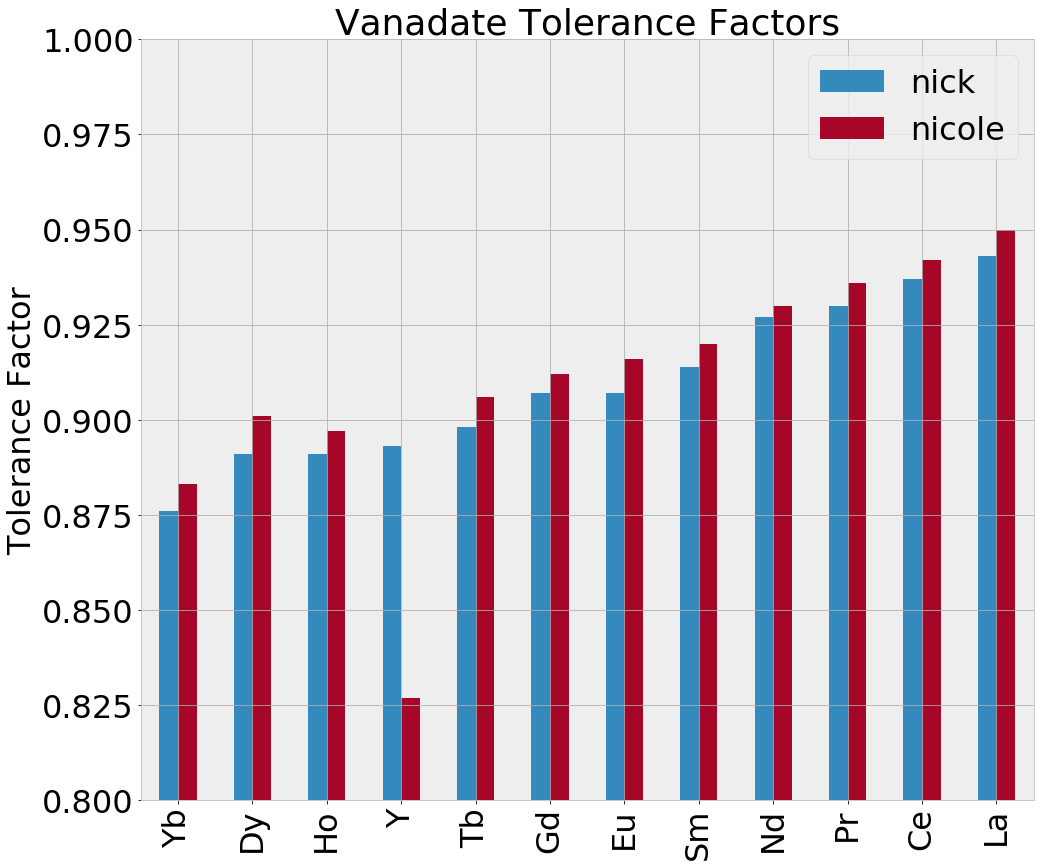

In [6]:
ax = vanadates.plot.bar(figsize=(16,14),fontsize=32)
ax.set_ylabel('Tolerance Factor', fontsize=32)
ax.set_ylim(0.8, 1)
ax.legend(fontsize=32)
ax.set_title('Vanadate Tolerance Factors', fontsize=36)
plt.show()

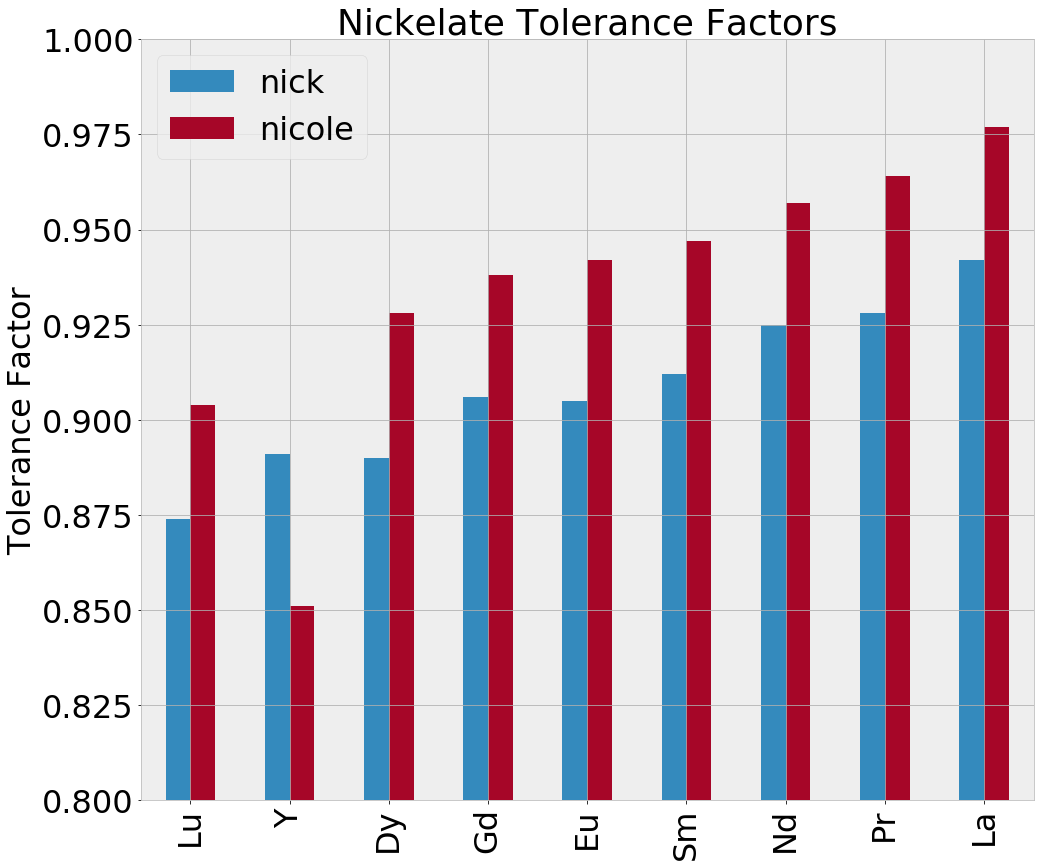

In [7]:
nickels = ['Lu', 'Y', 'Dy', 'Gd', 'Eu', 'Sm', 'Nd', 'Pr', 'La']
nicole = [0.904, 0.851, 0.928, 0.938, 0.942, 0.947, 0.957, 0.964, 0.977]
nick= []
for nickel in nickels:
    nick.append(float('{:0.3f}'.format(calc_tol_factor([nickel, 'Ni','O'], ['3+', '3+', '2-']))))

d = {'nicole': nicole, 'nick': nick}
nickelates = pd.DataFrame(data=d, index=nickels)
ax = nickelates.plot.bar(figsize=(16,14),fontsize=32)
ax.set_ylabel('Tolerance Factor', fontsize=32)
ax.set_ylim(0.8, 1)
ax.legend(fontsize=32)
ax.set_title('Nickelate Tolerance Factors', fontsize=36)
plt.show()